In [1]:
# GPU ON in Settings → Accelerator → GPU (recommended for later embedding)
!pip -q install biopython > /dev/null

import os, re, json, time, random
from typing import List, Tuple
from Bio import AlignIO, SeqIO

def log(msg): print(f"[{time.strftime('%H:%M:%S')}] {msg}")

# Where to write outputs (Kaggle persists this on "Save Version → Run")
WORKDIR = "/kaggle/working/work"
os.makedirs(WORKDIR, exist_ok=True)

# Where Kaggle mounted your uploaded dataset of .alignment.seed files
# (adjust this slug if your dataset name differs)
INPUT_DATASET = "/kaggle/input/sequences-fidelity"


In [2]:
# Families (2 positives + 4 negatives)
FAMILIES = ["PF00096","PF00036","PF00005","PF00072","PF00076","PF00013"]
POSITIVE_FAMS = ["PF00096","PF00036"]

# Amino-acid cleaning
ALLOW_AA = set("ACDEFGHIKLMNPQRSTVWYUX")
RARE_TO_X = re.compile(r"[UZOB]")

# Reproducible shuffle
RANDOM_SEED = 2025
random.seed(RANDOM_SEED)


In [3]:
# Cell 3 — FIXED: Stockholm → clean ungapped FASTA (no letter-annotation issue)
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def stockholm_to_fasta(in_path: str, out_path: str):
    """
    Converts Pfam/InterPro SEED Stockholm alignment to ungapped FASTA:
      - removes gaps '-'
      - uppercases
      - maps U/Z/O/B → X
      - keeps only standard letters
    Builds NEW SeqRecords (avoids letter-annotation length mismatch).
    """
    aln = AlignIO.read(open(in_path), "stockholm")
    clean_records = []
    for rec in aln:
        seq = str(rec.seq)
        seq = re.sub(r"[^A-Za-z\-]", "", seq).replace("-", "").upper()
        seq = RARE_TO_X.sub("X", seq)
        seq = "".join([c for c in seq if c in ALLOW_AA])
        if not seq:
            continue
        # make a NEW record (don’t mutate the old one)
        clean_records.append(SeqRecord(Seq(seq), id=rec.id, description=""))

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w") as out:
        SeqIO.write(clean_records, out, "fasta")
    log(f"Wrote {len(clean_records)} sequences → {out_path}")


In [4]:
RAW_BASE = f"{WORKDIR}/raw"
os.makedirs(RAW_BASE, exist_ok=True)

for acc in FAMILIES:
    in_path  = os.path.join(INPUT_DATASET, f"{acc}.alignment.seed")
    out_path = os.path.join(RAW_BASE, acc, "seed.fasta")
    if not os.path.exists(in_path):
        raise FileNotFoundError(f"Missing {in_path}. Make sure it’s in the input dataset.")
    stockholm_to_fasta(in_path, out_path)


[21:52:29] Wrote 159 sequences → /kaggle/working/work/raw/PF00096/seed.fasta
[21:52:29] Wrote 560 sequences → /kaggle/working/work/raw/PF00036/seed.fasta
[21:52:29] Wrote 55 sequences → /kaggle/working/work/raw/PF00005/seed.fasta
[21:52:29] Wrote 52 sequences → /kaggle/working/work/raw/PF00072/seed.fasta
[21:52:29] Wrote 68 sequences → /kaggle/working/work/raw/PF00076/seed.fasta
[21:52:29] Wrote 738 sequences → /kaggle/working/work/raw/PF00013/seed.fasta


In [5]:
def load_fasta_pairs(path: str) -> List[Tuple[str,str]]:
    pairs=[]; name=None; buf=[]
    with open(path) as f:
        for line in f:
            line=line.strip()
            if not line: continue
            if line.startswith(">"):
                if name is not None:
                    pairs.append((name,"".join(buf))); buf=[]
                name=line[1:].split()[0]
            else:
                buf.append(line)
    if name is not None:
        pairs.append((name,"".join(buf)))
    return pairs

def save_fasta_pairs(pairs: List[Tuple[str,str]], path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path,"w") as f:
        for rid, seq in pairs:
            f.write(f">{rid}\n")
            for i in range(0,len(seq),80):
                f.write(seq[i:i+80]+"\n")

def shuffle_pairs(pairs: List[Tuple[str,str]], seed=2025) -> List[Tuple[str,str]]:
    rnd = random.Random(seed)
    out=[]
    for rid, s in pairs:
        arr=list(s); rnd.shuffle(arr)
        out.append((f"{rid}|shuf","".join(arr)))
    return out

for acc in POSITIVE_FAMS:
    src = f"{RAW_BASE}/{acc}/seed.fasta"
    dst = f"{RAW_BASE}/{acc}/seed_shuf.fasta"
    pairs = load_fasta_pairs(src)
    shuf  = shuffle_pairs(pairs, RANDOM_SEED)
    save_fasta_pairs(shuf, dst)
    log(f"{acc}: pos={len(pairs)} shuf={len(shuf)} → {dst}")


[21:52:29] PF00096: pos=159 shuf=159 → /kaggle/working/work/raw/PF00096/seed_shuf.fasta
[21:52:29] PF00036: pos=560 shuf=560 → /kaggle/working/work/raw/PF00036/seed_shuf.fasta


In [6]:
def fasta_len_stats(path):
    L, cur = [], None
    with open(path) as f:
        for line in f:
            if line.startswith(">"):
                if cur is not None: L.append(len(cur))
                cur = ""
            else:
                cur = (cur or "") + line.strip()
    if cur: L.append(len(cur))
    return len(L), (min(L), max(L))

for acc in FAMILIES:
    fa = f"{RAW_BASE}/{acc}/seed.fasta"
    n,(mn,mx)=fasta_len_stats(fa)
    print(f"{acc}: n={n}, length {mn}..{mx}")
for acc in POSITIVE_FAMS:
    fa = f"{RAW_BASE}/{acc}/seed_shuf.fasta"
    n,(mn,mx)=fasta_len_stats(fa)
    print(f"{acc} (shuf): n={n}, length {mn}..{mx}")


PF00096: n=159, length 22..28
PF00036: n=560, length 27..29
PF00005: n=55, length 111..231
PF00072: n=52, length 109..122
PF00076: n=68, length 63..75
PF00013: n=738, length 48..80
PF00096 (shuf): n=159, length 22..28
PF00036 (shuf): n=560, length 27..29


In [7]:
!pip -q install torch transformers > /dev/null


In [8]:
import os, json, time, numpy as np, torch
from transformers import AutoTokenizer, AutoModel

EMB_BASE = "/kaggle/working/work/embeddings"
RAW_BASE = "/kaggle/working/work/raw"

# Which models to run (you can comment out any to shorten runtime)
RUN_MODELS = ["esm2", "protbert", "protxlnet"]

# Safe batch sizes for Kaggle T4
BATCH_SIZES = {"esm2": 4, "protbert": 8, "protxlnet": 8}

# Mixed precision (helps speed/mem). Set to None if you hit issues.
AMP_DTYPE = "fp16"   # "fp16", "bf16", or None

class HFModelSpec:
    def __init__(self, key, model_id, n_layers, space_sep, max_len):
        self.key = key
        self.model_id = model_id
        self.n_layers = n_layers
        self.space_sep = space_sep  # ProtBERT/XLNet need space-separated residues
        self.max_len = max_len

HF_SPECS = {
    "esm2":      HFModelSpec("esm2",      "facebook/esm2_t33_650M_UR50D", 33, False, 4096),
    "protbert":  HFModelSpec("protbert",  "Rostlab/prot_bert",            30, True, 1024),
    "protxlnet": HFModelSpec("protxlnet", "Rostlab/prot_xlnet",           36, True, 1024),
}

def space_sep(seq: str) -> str:
    return " ".join(list(seq))

def l2norm(x: np.ndarray, axis=-1, eps=1e-9) -> np.ndarray:
    n = np.linalg.norm(x, ord=2, axis=axis, keepdims=True)
    n = np.maximum(n, eps)
    return x / n

def read_fasta_lines(path: str):
    names, seqs = [], []
    with open(path) as f:
        name, buf = None, []
        for line in f:
            line = line.rstrip("\n")
            if not line: continue
            if line.startswith(">"):
                if name is not None:
                    seqs.append("".join(buf)); buf=[]
                name = line[1:].split()[0]
                names.append(name)
            else:
                buf.append(line)
        if name is not None:
            seqs.append("".join(buf))
    return names, seqs

# REPLACE your mean_pool with this masked version
def mean_pool_masked(hidden, input_ids, attention_mask, tokenizer):
    """
    hidden: [B,T,H], input_ids: [B,T], attention_mask: [B,T]
    Excludes special tokens (CLS/SEP/PAD/BOS/EOS) from the mean.
    Returns [B,H]; L2-normalized.
    """
    mask = attention_mask.clone()  # PAD=0; CLS/SEP are usually 1 (so we must drop them)
    special_ids = set()
    for attr in ["cls_token_id", "sep_token_id", "pad_token_id", "bos_token_id", "eos_token_id"]:
        sid = getattr(tokenizer, attr, None)
        if sid is not None:
            special_ids.add(sid)
    for sid in special_ids:
        mask = mask.masked_fill(input_ids == sid, 0)

    mask = mask.float()
    denom = mask.sum(dim=1, keepdim=True).clamp(min=1.0)
    pooled = (hidden * mask.unsqueeze(-1)).sum(dim=1) / denom
    pooled = torch.nn.functional.normalize(pooled, p=2, dim=-1)
    return pooled



In [9]:
def embed_fasta_to_layers(model_key: str, fasta_path: str, out_dir: str):
    spec = HF_SPECS[model_key]
    names, seqs = read_fasta_lines(fasta_path)
    texts = [space_sep(s) if spec.space_sep else s for s in seqs]


    tok = AutoTokenizer.from_pretrained(spec.model_id, do_lower_case=False, use_fast=False)
    model = AutoModel.from_pretrained(spec.model_id, output_hidden_states=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    if AMP_DTYPE == "fp16": amp_dtype = torch.float16
    elif AMP_DTYPE == "bf16": amp_dtype = torch.bfloat16
    else: amp_dtype = None

    bs = BATCH_SIZES.get(model_key, 8)
    layers = list(range(1, spec.n_layers + 1))
    bufs = {L: [] for L in layers}

    t0 = time.time()
    with torch.no_grad():
        for i in range(0, len(texts), bs):
            batch = texts[i:i+bs]
            enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=spec.max_len)
            enc = {k: v.to(device) for k, v in enc.items()}
            if amp_dtype is not None:
                with torch.autocast(device_type=device, dtype=amp_dtype):
                    out = model(**enc)
            else:
                out = model(**enc)
            hs_all = out.hidden_states  # tuple: 0..n_layers

            for L in layers:
                HS = hs_all[L]  # [B,T,H]
                pooled = mean_pool_masked(HS, enc["input_ids"], enc["attention_mask"], tok)  # <-- use masked
                pooled = pooled.detach().cpu().numpy()
                bufs[L].append(pooled)

    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir, "ids.json"), "w") as f:
        json.dump(names, f)

    for L in layers:
        arr = np.concatenate(bufs[L], axis=0)
        arr = l2norm(arr, axis=1)
        np.save(os.path.join(out_dir, f"layer_{L}.npy"), arr)

    mins = (time.time() - t0) / 60
    print(f"[{model_key}] {os.path.basename(fasta_path)} → saved {len(layers)} layers "
          f"(n={len(names)}) in {mins:.1f} min")









In [10]:
# Folder layout: embeddings/<model>/<PFxxxx>/<split>/{layer_*.npy, ids.json}
os.makedirs(EMB_BASE, exist_ok=True)

POSITIVES = ["PF00096","PF00036"]
NEGATIVES = ["PF00005","PF00072","PF00076","PF00013"]

def run_split(model_key, acc, split, fasta_name):
    in_fa = f"{RAW_BASE}/{acc}/{fasta_name}"
    if not os.path.exists(in_fa):
        print(f"[skip] missing {in_fa}")
        return
    out_dir = f"{EMB_BASE}/{model_key}/{acc}/{split}"
    embed_fasta_to_layers(model_key, in_fa, out_dir)

print("=== Starting embeddings ===")
t_all = time.time()
for model_key in RUN_MODELS:
    # positives + shuffles
    for acc in POSITIVES:
        run_split(model_key, acc, "pos",  "seed.fasta")
        run_split(model_key, acc, "shuf", "seed_shuf.fasta")
    # negatives (each kept separate)
    for acc in NEGATIVES:
        run_split(model_key, acc, "all",  "seed.fasta")
print(f"=== Done in {(time.time()-t_all)/60:.1f} min ===")


=== Starting embeddings ===


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

2025-09-05 21:54:13.892689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757109254.092350      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757109254.144491      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed.fasta → saved 33 layers (n=159) in 0.1 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed_shuf.fasta → saved 33 layers (n=159) in 0.0 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed.fasta → saved 33 layers (n=560) in 0.2 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed_shuf.fasta → saved 33 layers (n=560) in 0.1 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed.fasta → saved 33 layers (n=55) in 0.0 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed.fasta → saved 33 layers (n=52) in 0.0 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed.fasta → saved 33 layers (n=68) in 0.0 min


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[esm2] seed.fasta → saved 33 layers (n=738) in 0.3 min


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

[protbert] seed.fasta → saved 30 layers (n=159) in 0.0 min
[protbert] seed_shuf.fasta → saved 30 layers (n=159) in 0.0 min
[protbert] seed.fasta → saved 30 layers (n=560) in 0.1 min
[protbert] seed_shuf.fasta → saved 30 layers (n=560) in 0.1 min
[protbert] seed.fasta → saved 30 layers (n=55) in 0.0 min
[protbert] seed.fasta → saved 30 layers (n=52) in 0.0 min
[protbert] seed.fasta → saved 30 layers (n=68) in 0.0 min
[protbert] seed.fasta → saved 30 layers (n=738) in 0.2 min


config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.64G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.64G [00:00<?, ?B/s]

IndexError: tuple index out of range

In [12]:
# PATCH: use model.config.num_hidden_layers to decide how many hidden_states to save
def embed_fasta_to_layers(model_key: str, fasta_path: str, out_dir: str):
    spec = HF_SPECS[model_key]
    names, seqs = read_fasta_lines(fasta_path)
    texts = [space_sep(s) if spec.space_sep else s for s in seqs]

    tok = AutoTokenizer.from_pretrained(spec.model_id, do_lower_case=False, use_fast=False)
    model = AutoModel.from_pretrained(spec.model_id, output_hidden_states=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    # Decide AMP dtype
    if AMP_DTYPE == "fp16": amp_dtype = torch.float16
    elif AMP_DTYPE == "bf16": amp_dtype = torch.bfloat16
    else: amp_dtype = None

    bs = BATCH_SIZES.get(model_key, 8)

    # Use the model's REAL layer count (hidden_states has 0=embeddings, 1..n)
    n_layers = int(getattr(model.config, "num_hidden_layers", spec.n_layers))
    layers = list(range(1, n_layers + 1))
    bufs = {L: [] for L in layers}

    t0 = time.time()
    with torch.no_grad():
        for i in range(0, len(texts), bs):
            batch = texts[i:i+bs]
            enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=spec.max_len)
            enc = {k: v.to(device) for k, v in enc.items()}

            if amp_dtype is not None:
                with torch.autocast(device_type=device, dtype=amp_dtype):
                    out = model(**enc)
            else:
                out = model(**enc)

            hs_all = out.hidden_states  # tuple length should be n_layers+1
            # Guard in case some models expose fewer layers than config says
            avail = len(hs_all) - 1
            if avail < n_layers:
                # shrink once (first time we see this)
                if len(layers) != avail:
                    layers = list(range(1, avail + 1))
                    bufs = {L: [] for L in layers}
                    n_layers = avail
            for L in layers:
                HS = hs_all[L]  # [B, T, H]
                pooled = mean_pool_masked(HS, enc["input_ids"], enc["attention_mask"], tok)  # <-- use masked
                pooled = pooled.detach().cpu().numpy()
                bufs[L].append(pooled)

    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir, "ids.json"), "w") as f:
        json.dump(names, f)

    for L in layers:
        arr = np.concatenate(bufs[L], axis=0)
        arr = l2norm(arr, axis=1)
        np.save(os.path.join(out_dir, f"layer_{L}.npy"), arr)

    mins = (time.time() - t0) / 60
    print(f"[{model_key}] {os.path.basename(fasta_path)} → saved {len(layers)} layers "
          f"(n={len(names)}) in {mins:.1f} min")


In [13]:
# Re-run only ProtXLNet splits that failed / not yet written
model_key = "protxlnet"
POSITIVES = ["PF00096","PF00036"]
NEGATIVES = ["PF00005","PF00072","PF00076","PF00013"]

def run_split(model_key, acc, split, fasta_name):
    in_fa = f"{RAW_BASE}/{acc}/{fasta_name}"
    if not os.path.exists(in_fa):
        print(f"[skip] missing {in_fa}")
        return
    out_dir = f"{EMB_BASE}/{model_key}/{acc}/{split}"
    embed_fasta_to_layers(model_key, in_fa, out_dir)

for acc in POSITIVES:
    run_split(model_key, acc, "pos",  "seed.fasta")
    run_split(model_key, acc, "shuf", "seed_shuf.fasta")
for acc in NEGATIVES:
    run_split(model_key, acc, "all",  "seed.fasta")


[protxlnet] seed.fasta → saved 30 layers (n=159) in 0.0 min
[protxlnet] seed_shuf.fasta → saved 30 layers (n=159) in 0.0 min
[protxlnet] seed.fasta → saved 30 layers (n=560) in 0.1 min
[protxlnet] seed_shuf.fasta → saved 30 layers (n=560) in 0.1 min
[protxlnet] seed.fasta → saved 30 layers (n=55) in 0.0 min
[protxlnet] seed.fasta → saved 30 layers (n=52) in 0.0 min
[protxlnet] seed.fasta → saved 30 layers (n=68) in 0.0 min
[protxlnet] seed.fasta → saved 30 layers (n=738) in 0.2 min


In [14]:
import os, json
import torch
from transformers import AutoModel

EMB_BASE = "/kaggle/working/work/embeddings"
MODELS = {
    "esm2":      "facebook/esm2_t33_650M_UR50D",
    "protbert":  "Rostlab/prot_bert",
    "protxlnet": "Rostlab/prot_xlnet",
}
FAMS_POS = ["PF00096","PF00036"]
FAMS_NEG = ["PF00005","PF00072","PF00076","PF00013"]

def expected_layers(model_key):
    m = AutoModel.from_pretrained(MODELS[model_key])
    return int(getattr(m.config, "num_hidden_layers", 0))

def count_layers(path):
    return len([p for p in os.listdir(path) if p.endswith(".npy")])

def check_split(model_key, acc, split):
    d = f"{EMB_BASE}/{model_key}/{acc}/{split}"
    if not os.path.isdir(d):
        return f"{model_key}/{acc}/{split}: ✖ missing folder"
    exp = expected_layers(model_key)
    got = count_layers(d)
    ok_ids = os.path.exists(os.path.join(d,"ids.json"))
    mark = "✔" if (got == exp and ok_ids) else "⚠"
    return f"{model_key}/{acc}/{split}: {mark} {got}/{exp} layers, ids.json={'yes' if ok_ids else 'no'}"

rows=[]
for mk in MODELS:
    for acc in FAMS_POS:
        rows.append(check_split(mk, acc, "pos"))
        rows.append(check_split(mk, acc, "shuf"))
    for acc in FAMS_NEG:
        rows.append(check_split(mk, acc, "all"))
print("\n".join(rows))


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler

esm2/PF00096/pos: ✔ 33/33 layers, ids.json=yes
esm2/PF00096/shuf: ✔ 33/33 layers, ids.json=yes
esm2/PF00036/pos: ✔ 33/33 layers, ids.json=yes
esm2/PF00036/shuf: ✔ 33/33 layers, ids.json=yes
esm2/PF00005/all: ✔ 33/33 layers, ids.json=yes
esm2/PF00072/all: ✔ 33/33 layers, ids.json=yes
esm2/PF00076/all: ✔ 33/33 layers, ids.json=yes
esm2/PF00013/all: ✔ 33/33 layers, ids.json=yes
protbert/PF00096/pos: ✔ 30/30 layers, ids.json=yes
protbert/PF00096/shuf: ✔ 30/30 layers, ids.json=yes
protbert/PF00036/pos: ✔ 30/30 layers, ids.json=yes
protbert/PF00036/shuf: ✔ 30/30 layers, ids.json=yes
protbert/PF00005/all: ✔ 30/30 layers, ids.json=yes
protbert/PF00072/all: ✔ 30/30 layers, ids.json=yes
protbert/PF00076/all: ✔ 30/30 layers, ids.json=yes
protbert/PF00013/all: ✔ 30/30 layers, ids.json=yes
protxlnet/PF00096/pos: ✔ 30/30 layers, ids.json=yes
protxlnet/PF00096/shuf: ✔ 30/30 layers, ids.json=yes
protxlnet/PF00036/pos: ✔ 30/30 layers, ids.json=yes
protxlnet/PF00036/shuf: ✔ 30/30 layers, ids.json=yes
pr

In [16]:
!du -sh /kaggle/working/work/embeddings


933M	/kaggle/working/work/embeddings


In [17]:
%cd /kaggle/working
!zip -r embeddings.zip work/embeddings


/kaggle/working
  adding: work/embeddings/ (stored 0%)
  adding: work/embeddings/protxlnet/ (stored 0%)
  adding: work/embeddings/protxlnet/PF00013/ (stored 0%)
  adding: work/embeddings/protxlnet/PF00013/all/ (stored 0%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_4.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_3.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_27.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_14.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_23.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_18.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_8.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_22.npy (deflated 7%)
  adding: work/embeddings/protxlnet/PF00013/all/ids.json (deflated 61%)
  adding: work/embeddings/protxlnet/PF00013/all/layer_25.npy (deflated 7%)
  adding: work/embeddings/protxlne

In [18]:
import os, json, csv, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

EMB_BASE   = Path("/kaggle/working/work/embeddings")
RESULT_DIR = Path("/kaggle/working/work/results"); RESULT_DIR.mkdir(parents=True, exist_ok=True)

POS_FAMS = ["PF00096","PF00036"]
NEG_FAMS = ["PF00005","PF00072","PF00076","PF00013"]
MODELS   = ["esm2","protbert","protxlnet"]

def load_layer_matrix(model_key, acc, split, L):
    p = EMB_BASE / model_key / acc / split / f"layer_{L}.npy"
    return np.load(p)  # [n, d], already L2-normalized

def mean_intra_cos(X: np.ndarray) -> float:
    # avg over off-diagonal pairs: mean of upper triangle * 2 / (n*(n-1))
    S = X @ X.T
    n = S.shape[0]
    if n < 2: return np.nan
    # sum of all off-diagonal = total - trace
    total = S.sum() - np.trace(S)
    return float(total / (n*(n-1)))

def mean_cross_cos(X: np.ndarray, Y: np.ndarray) -> float:
    return float((X @ Y.T).mean())

def out_list_per_negative(X_pos, model_key, L):
    vals = []
    for neg in NEG_FAMS:
        Y = load_layer_matrix(model_key, neg, "all", L)
        vals.append(mean_cross_cos(X_pos, Y))
    return np.array(vals, dtype=np.float64)

def bootstrap_mean_ci(values: np.ndarray, n_boot=5000, alpha=0.05, seed=42):
    # bootstrap resampling over negatives (macro mean uncertainty)
    rng = np.random.default_rng(seed)
    m = len(values)
    if m == 0:
        return (np.nan, np.nan, np.nan)
    boots = rng.choice(values, size=(n_boot, m), replace=True).mean(axis=1)
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return float(values.mean()), float(lo), float(hi)

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def model_layers(model_key: str):
    # infer layer list from any existing split folder
    base = EMB_BASE / model_key
    any_split = (list((base).glob("*/pos")) or list((base).glob("*/all")))[0]
    Ls = sorted(int(pp.stem.split("_")[1]) for pp in any_split.glob("layer_*.npy"))
    return Ls


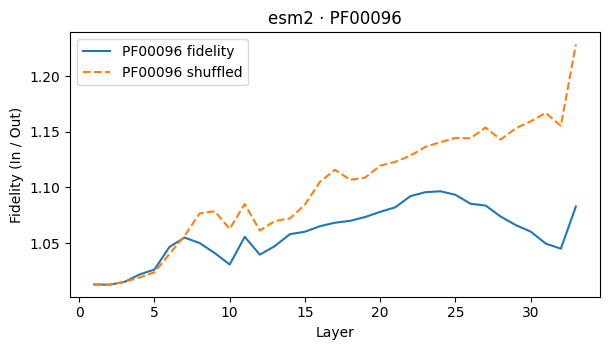

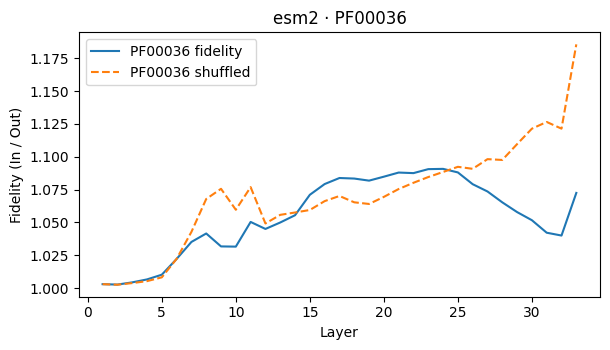

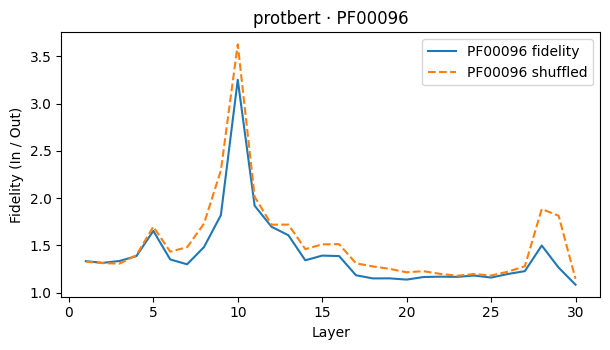

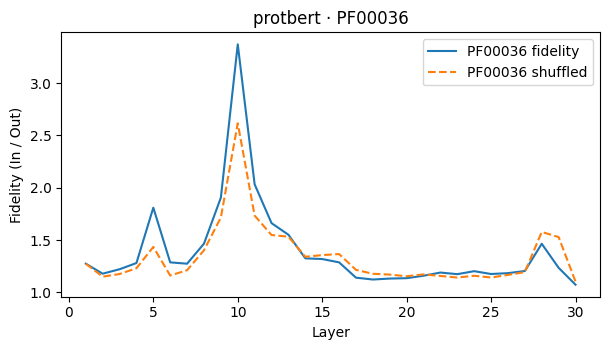

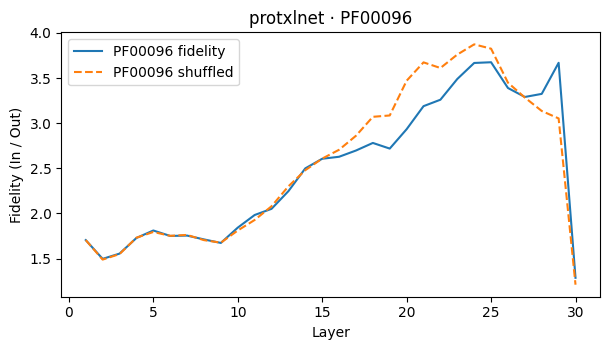

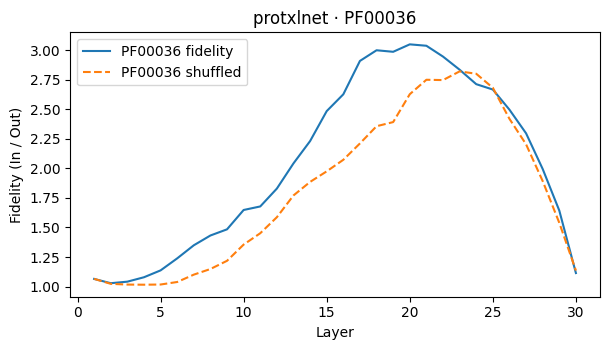

Saved all-layer results to: /kaggle/working/work/results/family_fidelity_all.csv
Saved key-layer table to: /kaggle/working/work/results/family_fidelity_key_layers.csv


,model,family,layer,In,Out_macro,Out_lo,Out_hi,Delta,Fidelity,Fidelity_shuf
0,esm2,PF00096,1,0.973963,0.961744,0.960577,0.963336,0.012219,1.012705,1.012788
1,esm2,PF00096,17,0.989017,0.925769,0.914291,0.937050,0.063248,1.068319,1.115937
2,esm2,PF00096,33,0.967862,0.893713,0.877702,0.909723,0.074149,1.082968,1.228817
3,esm2,PF00036,1,0.984399,0.981386,0.980314,0.982458,0.003013,1.003070,1.003059
4,esm2,PF00036,17,0.988353,0.911898,0.904172,0.918589,0.076454,1.083841,1.070165
5,esm2,PF00036,33,0.974206,0.908358,0.889946,0.926771,0.065848,1.072491,1.185532
6,protbert,PF00096,1,0.945444,0.709554,0.632866,0.786242,0.235890,1.332448,1.327239
7,protbert,PF00096,16,0.915118,0.660094,0.635351,0.684836,0.255025,1.386346,1.512201
8,protbert,PF00096,30,0.968406,0.894102,0.857927,0.930277,0.074304,1.083105,1.144767
9,protbert,PF00036,1,0.965519,0.757918,0.689188,0.826649,0.207601,1.273909,1.273415


In [19]:
# One wide CSV with all results
ALL_CSV = RESULT_DIR / "family_fidelity_all.csv"
with open(ALL_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["model","family","layer","In","Out_macro","Out_lo","Out_hi","Delta","Fidelity","In_shuf","Out_shuf","Fidelity_shuf"])

    for model_key in MODELS:
        layers = model_layers(model_key)
        # per-model per-family plot
        for fam in POS_FAMS:
            fid_vals, fid_shuf_vals = [], []
            Ls = []

            for L in layers:
                X_pos  = load_layer_matrix(model_key, fam, "pos",  L)
                X_shuf = load_layer_matrix(model_key, fam, "shuf", L)

                In  = mean_intra_cos(X_pos)
                InS = mean_intra_cos(X_shuf)

                outs_list    = out_list_per_negative(X_pos,  model_key, L)
                outs_list_S  = out_list_per_negative(X_shuf, model_key, L)

                Out_macro, Olo, Ohi = bootstrap_mean_ci(outs_list, n_boot=3000, alpha=0.05, seed=123)
                Out_shuf            = float(outs_list_S.mean()) if len(outs_list_S) else np.nan

                Delta    = In - Out_macro
                Fidelity = In / Out_macro if Out_macro > 0 else np.nan
                FidS     = InS / Out_shuf  if Out_shuf  > 0 else np.nan

                w.writerow([model_key, fam, L, In, Out_macro, Olo, Ohi, Delta, Fidelity, InS, Out_shuf, FidS])

                fid_vals.append(Fidelity)
                fid_shuf_vals.append(FidS)
                Ls.append(L)

            # Plot Fidelity vs layer (+ shuffled)
            plt.figure(figsize=(6.2,3.6))
            plt.plot(Ls, fid_vals, label=f"{fam} fidelity")
            plt.plot(Ls, fid_shuf_vals, linestyle="--", label=f"{fam} shuffled")
            plt.xlabel("Layer")
            plt.ylabel("Fidelity (In / Out)")
            plt.title(f"{model_key} · {fam}")
            plt.legend()
            plt.tight_layout()
            fig_path = RESULT_DIR / f"{model_key}_{fam}_fidelity.png"
            plt.savefig(fig_path, dpi=300)
            plt.show()

print(f"Saved all-layer results to: {ALL_CSV}")

# Also write a compact "key layers" table for the paper main figure (early/mid/late)
KEY_CSV = RESULT_DIR / "family_fidelity_key_layers.csv"
with open(KEY_CSV, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["model","family","layer","In","Out_macro","Out_lo","Out_hi","Delta","Fidelity","Fidelity_shuf"])
    # load full table in-memory once
    import pandas as pd
    df = pd.read_csv(ALL_CSV)
    for model_key in MODELS:
        layers = sorted(df[df.model==model_key].layer.unique())
        if not layers: continue
        pick = [layers[0], layers[len(layers)//2], layers[-1]]  # early/mid/late
        for fam in POS_FAMS:
            sub = df[(df.model==model_key) & (df.family==fam) & (df.layer.isin(pick))].sort_values("layer")
            for _, r in sub.iterrows():
                w.writerow([r.model, r.family, int(r.layer), r.In, r.Out_macro, r.Out_lo, r.Out_hi, r.Delta, r.Fidelity, r.Fidelity_shuf])

print(f"Saved key-layer table to: {KEY_CSV}")

# OPTIONAL: quick on-screen preview of the key table
try:
    import pandas as pd
    display(pd.read_csv(KEY_CSV))
except Exception:
    pass


Saved: /kaggle/working/work/results/figure_fidelity_panels.png
Saved: /kaggle/working/work/results/figure_fidelity_panels.pdf


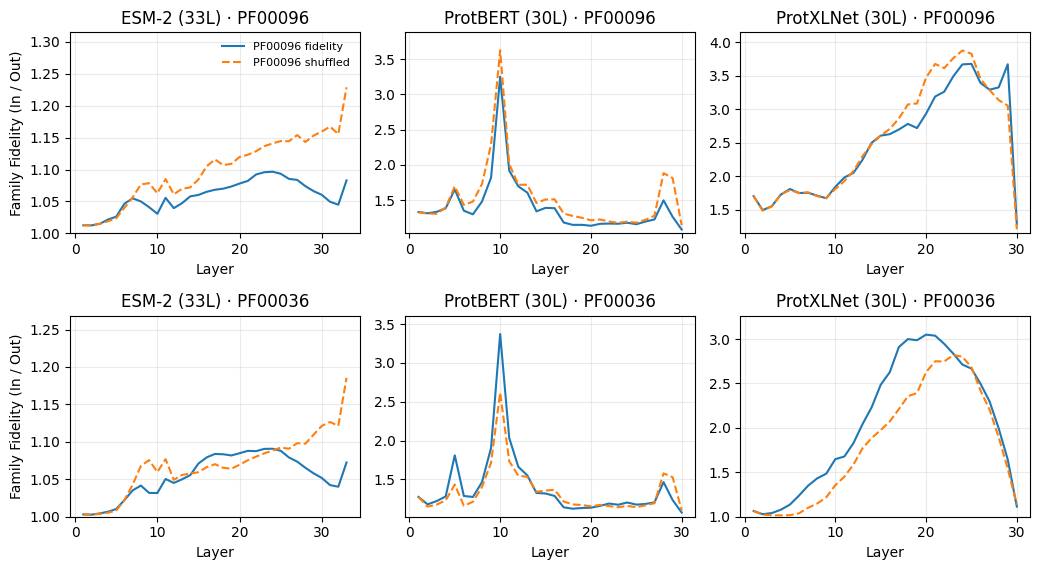

In [20]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

RESULT_DIR = Path("/kaggle/working/work/results")
EMB_BASE   = Path("/kaggle/working/work/embeddings")

df = pd.read_csv(RESULT_DIR / "family_fidelity_all.csv")
MODELS = ["esm2","protbert","protxlnet"]
FAMS   = ["PF00096","PF00036"]
TITLES = {"esm2":"ESM-2 (33L)","protbert":"ProtBERT (30L)","protxlnet":"ProtXLNet (30L)"}

def panel_limits(dfi):
    # keep Y sensible but adaptive; clamp floor at 1.0
    y = pd.concat([dfi["Fidelity"], dfi["Fidelity_shuf"]]).dropna()
    lo = max(1.0, float(y.min()*0.95))
    hi = float(y.max()*1.07)
    return lo, hi

fig, axes = plt.subplots(2, 3, figsize=(10.5, 5.8), sharex=False)
for j, model in enumerate(MODELS):
    for i, fam in enumerate(FAMS):
        ax = axes[i, j]
        sub = df[(df.model==model) & (df.family==fam)].sort_values("layer")
        lo, hi = panel_limits(sub)
        ax.plot(sub.layer, sub.Fidelity, label=f"{fam} fidelity")
        ax.plot(sub.layer, sub.Fidelity_shuf, linestyle="--", label=f"{fam} shuffled")
        ax.set_ylim(lo, hi)
        ax.set_xlabel("Layer")
        if j==0: ax.set_ylabel("Family Fidelity (In / Out)")
        ax.set_title(f"{TITLES.get(model, model)} · {fam}")
        ax.grid(True, alpha=0.25)
        if i==0 and j==0:
            ax.legend(frameon=False, fontsize=8)

fig.tight_layout(w_pad=1.0, h_pad=1.2)
fig.savefig(RESULT_DIR / "figure_fidelity_panels.png", dpi=300)
fig.savefig(RESULT_DIR / "figure_fidelity_panels.pdf")
print("Saved:", RESULT_DIR / "figure_fidelity_panels.png")
print("Saved:", RESULT_DIR / "figure_fidelity_panels.pdf")


In [21]:
import pandas as pd
from pathlib import Path

RESULT_DIR = Path("/kaggle/working/work/results")
key = pd.read_csv(RESULT_DIR / "family_fidelity_key_layers.csv")
def r(x): 
    try: return f"{float(x):.2f}"
    except: return x

tbl = key.copy()
tbl["In"]         = tbl["In"].map(r)
tbl["Out_macro"]  = tbl["Out_macro"].map(r)
tbl["Out_lo"]     = tbl["Out_lo"].map(r)
tbl["Out_hi"]     = tbl["Out_hi"].map(r)
tbl["Delta"]      = tbl["Delta"].map(r)
tbl["Fidelity"]   = tbl["Fidelity"].map(r)
tbl["Fidelity_shuf"] = tbl["Fidelity_shuf"].map(r)
tbl = tbl.rename(columns={"layer":"Layer","Out_lo":"Out (lo)","Out_hi":"Out (hi)"})
out_csv = RESULT_DIR / "table_main_key_layers.csv"
tbl.to_csv(out_csv, index=False)
tbl
print("Saved:", out_csv)


Saved: /kaggle/working/work/results/table_main_key_layers.csv


Saved: /kaggle/working/work/results/figure_delta_panels.png
Saved: /kaggle/working/work/results/figure_delta_panels.pdf


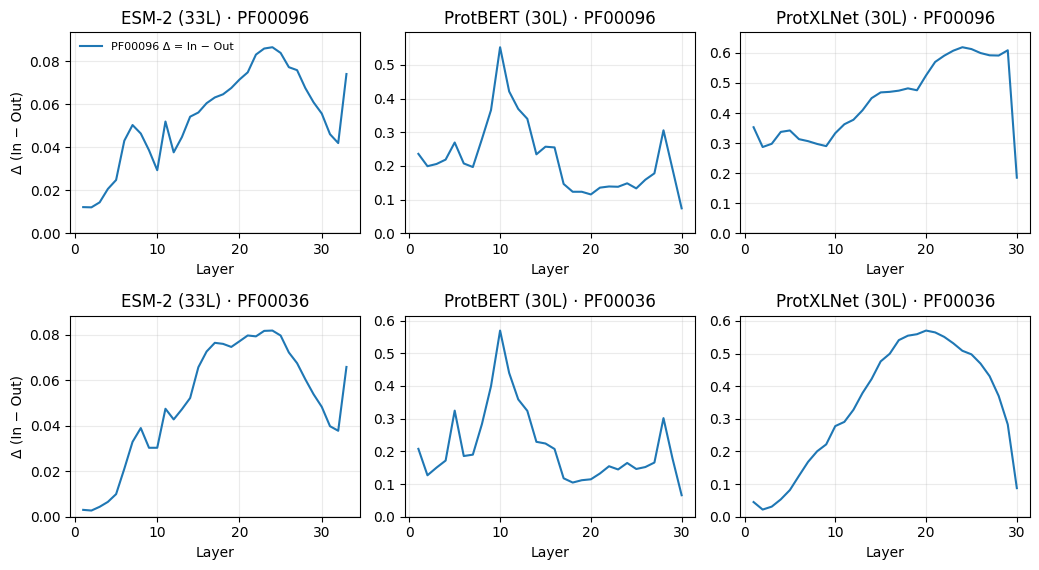

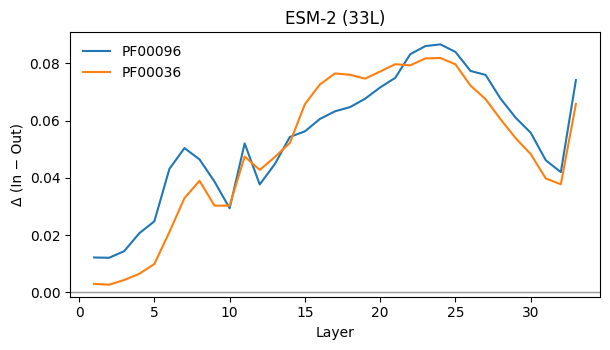

Saved: /kaggle/working/work/results/figure_esm2_delta.png


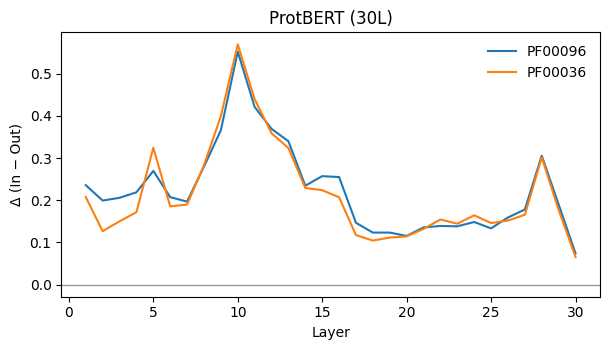

Saved: /kaggle/working/work/results/figure_protbert_delta.png


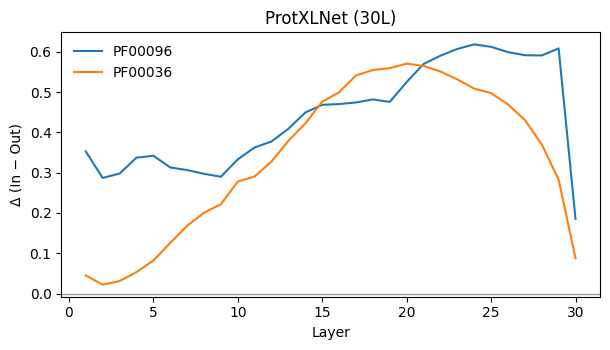

Saved: /kaggle/working/work/results/figure_protxlnet_delta.png


In [22]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

RESULT_DIR = Path("/kaggle/working/work/results")
df = pd.read_csv(RESULT_DIR / "family_fidelity_all.csv")

MODELS = ["esm2","protbert","protxlnet"]
FAMS   = ["PF00096","PF00036"]
TITLES = {"esm2":"ESM-2 (33L)","protbert":"ProtBERT (30L)","protxlnet":"ProtXLNet (30L)"}

def panel_limits_delta(dfi):
    y = dfi["Delta"].dropna()
    lo = min(0.0, float(y.min()*1.05))
    hi = float(y.max()*1.08)
    # avoid degenerate ranges
    if hi - lo < 1e-3:
        hi = lo + 0.05
    return lo, hi

# ---- Combined 2×3 figure ----
fig, axes = plt.subplots(2, 3, figsize=(10.5, 5.8), sharex=False)
for j, model in enumerate(MODELS):
    for i, fam in enumerate(FAMS):
        ax = axes[i, j]
        sub = df[(df.model==model) & (df.family==fam)].sort_values("layer")
        lo, hi = panel_limits_delta(sub)
        ax.plot(sub.layer, sub.Delta, label=f"{fam} Δ = In − Out")
        ax.axhline(0.0, color="black", linewidth=1.0, alpha=0.4)
        ax.set_ylim(lo, hi)
        ax.set_xlabel("Layer")
        if j==0: ax.set_ylabel("Δ (In − Out)")
        ax.set_title(f"{TITLES.get(model, model)} · {fam}")
        ax.grid(True, alpha=0.25)
        if i==0 and j==0:
            ax.legend(frameon=False, fontsize=8)

fig.tight_layout(w_pad=1.0, h_pad=1.2)
fig.savefig(RESULT_DIR / "figure_delta_panels.png", dpi=300)
fig.savefig(RESULT_DIR / "figure_delta_panels.pdf")
print("Saved:", RESULT_DIR / "figure_delta_panels.png")
print("Saved:", RESULT_DIR / "figure_delta_panels.pdf")

# ---- Optional: per-model figures (handy for slides) ----
for model in MODELS:
    plt.figure(figsize=(6.2,3.6))
    for fam in FAMS:
        sub = df[(df.model==model) & (df.family==fam)].sort_values("layer")
        plt.plot(sub.layer, sub.Delta, label=fam)
    plt.axhline(0.0, color="black", linewidth=1.0, alpha=0.4)
    plt.xlabel("Layer"); plt.ylabel("Δ (In − Out)")
    plt.title(f"{TITLES.get(model, model)}")
    plt.legend(frameon=False)
    plt.tight_layout()
    out = RESULT_DIR / f"figure_{model}_delta.png"
    plt.savefig(out, dpi=300); plt.show()
    print("Saved:", out)


In [23]:
# CELL A: Load saved layer stacks from disk
import json, glob

# these must match what you defined earlier
EMB_BASE = "/kaggle/working/work/embeddings"
POSITIVES = ["PF00096","PF00036"]
NEGATIVES = ["PF00005","PF00072","PF00076","PF00013"]

# map your keys to human names used in figures
MODEL_KEY_TO_NAME = {"esm2":"ESM-2", "protbert":"ProtBERT", "protxlnet":"ProtXLNet"}
RUN_MODELS = ["esm2","protbert","protxlnet"]

def load_layer_stack(model_key: str, acc: str, split: str):
    """
    Returns: arr [N,L,H], ids [N], with layers 1..L sorted by filename layer_*.npy
    """
    base = f"{EMB_BASE}/{model_key}/{acc}/{split}"
    with open(os.path.join(base, "ids.json")) as f:
        ids = json.load(f)
    files = sorted(glob.glob(os.path.join(base, "layer_*.npy")),
                   key=lambda p: int(os.path.basename(p).split("_")[1].split(".")[0]))
    mats = [np.load(p) for p in files]  # each [N,H]
    arr = np.stack(mats, axis=1)        # [N,L,H]
    return arr, ids

def build_negatives(model_key: str):
    """Concatenate negatives across the 4 families along N: returns [Nneg, L, H]."""
    stacks = []
    for acc in NEGATIVES:
        arr, _ = load_layer_stack(model_key, acc, "all")
        stacks.append(arr)
    return np.concatenate(stacks, axis=0)

def build_positives_and_shuf(model_key: str):
    pos, shuf = {}, {}
    for acc in POSITIVES:
        pos[acc], _  = load_layer_stack(model_key, acc, "pos")
        shuf[acc], _ = load_layer_stack(model_key, acc, "shuf")
    return pos, shuf


In [27]:
# CELL B (FAST): Compute curves (ratio & Δ) + 95% CIs using precomputed similarities
import numpy as np, time

# ---- Tunable knobs (speed vs precision) ----
B_BOOT       = 600    # bootstrap repetitions (400–800 good for dev; increase later if desired)
K_NEG        = 32     # negatives per positive when forming Out
MAX_IN_PAIRS = 20000  # max within-family pairs sampled per layer

rng_global = np.random.default_rng(2025)

def precompute_in_out_arrays(E_pos: np.ndarray, E_neg: np.ndarray,
                             k_neg: int = K_NEG, max_in_pairs: int = MAX_IN_PAIRS):
    """
    E_pos: [N_pos, H], E_neg: [N_neg, H] (both L2-normalized)
    Returns:
      sims_in_pairs: [P]  ~ sample of within-family pair cosine sims
      sims_out_per_pos: [N_pos]  mean cosine to k_neg negatives for each positive
    """
    Np, H = E_pos.shape
    Nn, _ = E_neg.shape

    # --- In-family pair sims (sample up to MAX_IN_PAIRS from upper triangle) ---
    total_pairs = Np * (Np - 1) // 2
    if total_pairs <= 0:
        sims_in_pairs = np.array([], dtype=np.float32)
    else:
        if total_pairs <= max_in_pairs:
            ii, jj = np.triu_indices(Np, k=1)
        else:
            # sample pairs uniformly with i<j
            P = max_in_pairs
            ii = rng_global.integers(0, Np-1, size=P)
            jj = rng_global.integers(0, Np-1, size=P)
            mask = jj <= ii
            attempts = 0
            while mask.any() and attempts < 1000:  # Add safety limit
                jj[mask] = rng_global.integers(0, Np-1, size=mask.sum())
                mask = jj <= ii
                attempts += 1
            if attempts >= 1000:
                print(f"    Warning: Pair sampling took {attempts} attempts - using current pairs")
        A = E_pos[ii]
        B = E_pos[jj]
        sims_in_pairs = np.einsum("ij,ij->i", A, B).astype(np.float32)  # dot = cosine (L2-normed)

    # --- Out mean per positive (fixed subset of k_neg negatives) ---
    k = min(k_neg, Nn) if Nn > 0 else 0
    if k == 0 or Np == 0:
        sims_out_per_pos = np.zeros((Np,), dtype=np.float32)
    else:
        choose = rng_global.choice(Nn, size=k, replace=False)
        sims_pk = E_pos @ E_neg[choose].T  # [Np,k]
        sims_out_per_pos = sims_pk.mean(axis=1).astype(np.float32)  # [Np]

    return sims_in_pairs, sims_out_per_pos

def point_estimate_from_arrays(sims_in_pairs: np.ndarray, sims_out_per_pos: np.ndarray):
    in_mean  = float(sims_in_pairs.mean()) if sims_in_pairs.size else 0.0
    out_mean = float(sims_out_per_pos.mean()) if sims_out_per_pos.size else 0.0
    ratio    = (in_mean / out_mean) if out_mean > 0 else np.nan
    delta    = in_mean - out_mean
    return in_mean, out_mean, ratio, delta

def fast_bootstrap_from_arrays(sims_in_pairs: np.ndarray, sims_out_per_pos: np.ndarray, B=B_BOOT):
    """
    Bootstrap by resampling:
      - within-family pair sims (length P)
      - per-positive out means (length N)
    No heavy matmul inside the loop → much faster.
    """
    P = sims_in_pairs.size
    N = sims_out_per_pos.size
    if P == 0 or N == 0:
        return (np.nan, np.nan), (np.nan, np.nan)

    r_vals = np.empty(B, dtype=np.float32)
    d_vals = np.empty(B, dtype=np.float32)
    for b in range(B):
        in_b  = sims_in_pairs[rng_global.integers(0, P, size=P)].mean()
        out_b = sims_out_per_pos[rng_global.integers(0, N, size=N)].mean()
        r_vals[b] = (in_b / out_b) if out_b > 0 else np.nan
        d_vals[b] = in_b - out_b

    r_lo, r_hi = np.nanpercentile(r_vals, [2.5, 97.5])
    d_lo, d_hi = np.nanpercentile(d_vals, [2.5, 97.5])
    return (float(r_lo), float(r_hi)), (float(d_lo), float(d_hi))

# ========== Build curves per model from on-disk embeddings ==========
curves_by_model = {}
L_by_model = {}

# You should already have:
#   RUN_MODELS = ["esm2","protbert","protxlnet"]
#   MODEL_KEY_TO_NAME = {"esm2":"ESM-2", "protbert":"ProtBERT", "protxlnet":"ProtXLNet"}
#   POSITIVES = ["PF00096","PF00036"]
# and the helpers:
#   build_positives_and_shuf(model_key) -> dicts
#   build_negatives(model_key) -> [Nneg, L, H]

total_models = len(RUN_MODELS)
for model_idx, model_key in enumerate(RUN_MODELS):
    model_name = MODEL_KEY_TO_NAME[model_key]
    print(f"[{model_idx+1}/{total_models}] [FAST] Computing metrics for {model_name} ...")
    
    try:
        pos, shuf = build_positives_and_shuf(model_key)
        neg = build_negatives(model_key)               # [Nneg,L,H]
        L   = neg.shape[1]
        L_by_model[model_name] = L
        curves_by_model[model_name] = {}
        
        print(f"    Loaded data: {len(pos)} families, {neg.shape[0]} negatives, {L} layers")
        
    except Exception as e:
        print(f"    ERROR loading data for {model_name}: {e}")
        continue

    total_families = len(POSITIVES)
    for fam_idx, fam in enumerate(POSITIVES):
        print(f"    [{fam_idx+1}/{total_families}] Processing family {fam}...")
        
        try:
            E_pos_true = pos[fam]    # [N,L,H]
            E_pos_shuf = shuf[fam]   # [N,L,H]
            print(f"      Data shapes: true={E_pos_true.shape}, shuf={E_pos_shuf.shape}")

            r_true, d_true, r_shuf, d_shuf = [], [], [], []
            r_true_ci, d_true_ci, r_shuf_ci, d_shuf_ci = [], [], [], []

            t0 = time.time()
            for l in range(L):
                # TRUE
                sims_in_t, sims_out_t = precompute_in_out_arrays(E_pos_true[:,l,:], neg[:,l,:],
                                                                 k_neg=K_NEG, max_in_pairs=MAX_IN_PAIRS)
                _, _, r_t, d_t = point_estimate_from_arrays(sims_in_t, sims_out_t)
                (rlo_t,rhi_t), (dlo_t,dhi_t) = fast_bootstrap_from_arrays(sims_in_t, sims_out_t, B=B_BOOT)
                r_true.append(r_t); d_true.append(d_t)
                r_true_ci.append((rlo_t, rhi_t)); d_true_ci.append((dlo_t, dhi_t))

                # SHUFFLED (advisor wants Δ shown too)
                sims_in_s, sims_out_s = precompute_in_out_arrays(E_pos_shuf[:,l,:], neg[:,l,:],
                                                                 k_neg=K_NEG, max_in_pairs=MAX_IN_PAIRS)
                _, _, r_s, d_s = point_estimate_from_arrays(sims_in_s, sims_out_s)
                (rlo_s,rhi_s), (dlo_s,dhi_s) = fast_bootstrap_from_arrays(sims_in_s, sims_out_s, B=B_BOOT)
                r_shuf.append(r_s); d_shuf.append(d_s)
                r_shuf_ci.append((rlo_s, rhi_s)); d_shuf_ci.append((dlo_s, dhi_s))

                # Progress every 5 layers or at the end
                if (l+1) % 5 == 0 or l == L-1:
                    elapsed = time.time() - t0
                    print(f"      {model_name} {fam}: layer {l+1}/{L} done ({elapsed:.1f}s elapsed)")

            curves_by_model[model_name][fam] = {
                "true": {"ratio": np.array(r_true), "delta": np.array(d_true),
                         "ratio_ci": np.array(r_true_ci), "delta_ci": np.array(d_true_ci)},
                "shuf": {"ratio": np.array(r_shuf), "delta": np.array(d_shuf),
                         "ratio_ci": np.array(r_shuf_ci), "delta_ci": np.array(d_shuf_ci)},
            }
            
            total_elapsed = time.time() - t0
            print(f"    [{fam_idx+1}/{total_families}] Completed {model_name} {fam} ({total_elapsed:.1f}s total)")
            
        except Exception as e:
            print(f"    ERROR processing {fam} for {model_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"[{model_idx+1}/{total_models}] Completed all families for {model_name}")

print("Done (FAST): curves + 95% CIs ready.")
print(f"Results available for models: {list(curves_by_model.keys())}")
for model_name in curves_by_model:
    families = list(curves_by_model[model_name].keys())
    print(f"  {model_name}: {len(families)} families - {families}")

[1/3] [FAST] Computing metrics for ESM-2 ...
    Loaded data: 2 families, 913 negatives, 33 layers
    [1/2] Processing family PF00096...
      Data shapes: true=(159, 33, 1280), shuf=(159, 33, 1280)
      ESM-2 PF00096: layer 5/33 done (1.1s elapsed)
      ESM-2 PF00096: layer 10/33 done (2.1s elapsed)
      ESM-2 PF00096: layer 15/33 done (3.2s elapsed)
      ESM-2 PF00096: layer 20/33 done (4.2s elapsed)
      ESM-2 PF00096: layer 25/33 done (5.2s elapsed)
      ESM-2 PF00096: layer 30/33 done (6.3s elapsed)
      ESM-2 PF00096: layer 33/33 done (6.9s elapsed)
    [1/2] Completed ESM-2 PF00096 (6.9s total)
    [2/2] Processing family PF00036...
      Data shapes: true=(560, 33, 1280), shuf=(560, 33, 1280)
      ESM-2 PF00036: layer 5/33 done (2.1s elapsed)
      ESM-2 PF00036: layer 10/33 done (4.3s elapsed)
      ESM-2 PF00036: layer 15/33 done (6.4s elapsed)
      ESM-2 PF00036: layer 20/33 done (8.5s elapsed)
      ESM-2 PF00036: layer 25/33 done (10.6s elapsed)
      ESM-2 PF000

In [32]:
# Diagnostic: Check CI ranges for all models
import numpy as np

print("=== CONFIDENCE INTERVAL RANGES DIAGNOSTIC ===\n")

for model_name in ["ESM-2", "ProtBERT", "ProtXLNet"]:
    print(f"--- {model_name} ---")
    for fam in ["PF00096", "PF00036"]:
        print(f"  {fam}:")
        
        # Ratio CIs
        true_ratio_ci = curves_by_model[model_name][fam]["true"]["ratio_ci"]
        shuf_ratio_ci = curves_by_model[model_name][fam]["shuf"]["ratio_ci"]
        
        true_ratio_width = np.mean(true_ratio_ci[:, 1] - true_ratio_ci[:, 0])
        shuf_ratio_width = np.mean(shuf_ratio_ci[:, 1] - shuf_ratio_ci[:, 0])
        
        print(f"    Ratio CI avg width: True={true_ratio_width:.4f}, Shuf={shuf_ratio_width:.4f}")
        
        # Delta CIs  
        true_delta_ci = curves_by_model[model_name][fam]["true"]["delta_ci"]
        shuf_delta_ci = curves_by_model[model_name][fam]["shuf"]["delta_ci"]
        
        true_delta_width = np.mean(true_delta_ci[:, 1] - true_delta_ci[:, 0])
        shuf_delta_width = np.mean(shuf_delta_ci[:, 1] - shuf_delta_ci[:, 0])
        
        print(f"    Delta CI avg width: True={true_delta_width:.4f}, Shuf={shuf_delta_width:.4f}")
        
        # Sample values for first few layers
        print(f"    Sample ratio values (layers 1-3): {curves_by_model[model_name][fam]['true']['ratio'][:3]}")
        print(f"    Sample ratio CI (layer 1): [{true_ratio_ci[0,0]:.3f}, {true_ratio_ci[0,1]:.3f}]")
        print()

print("\n=== RECOMMENDATIONS ===")
print("If ProtBERT has much smaller CI widths than other models:")
print("1. Its bootstrap estimates are more stable (less variance)")
print("2. CI ribbons will be barely visible even with higher alpha")
print("3. Consider using different alpha values per model, or")
print("4. Add subtle border lines to make narrow CIs more visible")

=== CONFIDENCE INTERVAL RANGES DIAGNOSTIC ===

--- ESM-2 ---
  PF00096:
    Ratio CI avg width: True=0.0021, Shuf=0.0073
    Delta CI avg width: True=0.0018, Shuf=0.0056
    Sample ratio values (layers 1-3): [1.0125397  1.01320761 1.01522225]
    Sample ratio CI (layer 1): [1.010, 1.015]

  PF00036:
    Ratio CI avg width: True=0.0008, Shuf=0.0030
    Delta CI avg width: True=0.0007, Shuf=0.0024
    Sample ratio values (layers 1-3): [1.0035607  1.00329827 1.00425548]
    Sample ratio CI (layer 1): [1.003, 1.004]

--- ProtBERT ---
  PF00096:
    Ratio CI avg width: True=0.0204, Shuf=0.0224
    Delta CI avg width: True=0.0085, Shuf=0.0079
    Sample ratio values (layers 1-3): [1.2021269  1.30247426 1.29763533]
    Sample ratio CI (layer 1): [1.198, 1.206]

  PF00036:
    Ratio CI avg width: True=0.0112, Shuf=0.0120
    Delta CI avg width: True=0.0040, Shuf=0.0056
    Sample ratio values (layers 1-3): [1.17785367 1.17726275 1.1873501 ]
    Sample ratio CI (layer 1): [1.177, 1.179]

--- Pr

In [35]:
# CELL C: Plot panels with 95% CI ribbons; True (solid) + Shuffled (dashed)
# FIXED: Proper axis scaling to distinguish ratio from delta, especially for ESM-2
import matplotlib.pyplot as plt, os
import numpy as np

def fill_ci(ax, x, ci_arr, alpha=0.4):
    """Enhanced CI with adaptive alpha based on width"""
    lo = ci_arr[:,0]; hi = ci_arr[:,1]
    avg_width = np.mean(hi - lo)
    
    # Adaptive alpha for visibility
    if avg_width < 0.005:      # Very narrow (ESM-2)
        alpha = 0.6
    elif avg_width < 0.02:     # Narrow (ProtBERT)
        alpha = 0.4
    else:                      # Normal (ProtXLNet)
        alpha = 0.3
    
    # Get main line color for consistent styling
    lines = ax.get_lines()
    main_color = lines[-1].get_color() if len(lines) > 0 else None
    
    ax.fill_between(x, lo, hi, alpha=alpha, linewidth=0, color=main_color)
    
    # Add boundary lines for narrow CIs
    if avg_width < 0.03:
        linestyle = ':' if len(lines) % 2 == 0 else '-.'  # Different styles for true/shuf
        ax.plot(x, lo, color=main_color, alpha=0.5, linewidth=0.7, linestyle=linestyle)
        ax.plot(x, hi, color=main_color, alpha=0.5, linewidth=0.7, linestyle=linestyle)

def plot_fidelity_panels(curves_by_model, L_by_model, out_path):
    fams = ["PF00096","PF00036"]; models = ["ESM-2","ProtBERT","ProtXLNet"]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=False, sharey=False)
    for r,fam in enumerate(fams):
        for c,model in enumerate(models):
            ax = axes[r, c]
            L = L_by_model[model]; x = np.arange(1, L+1)
            curves = curves_by_model[model][fam]
            
            # True
            ax.plot(x, curves["true"]["ratio"], label="True", linestyle="-", linewidth=1.8)
            fill_ci(ax, x, curves["true"]["ratio_ci"])
            # Shuffled
            ax.plot(x, curves["shuf"]["ratio"], label="Shuffled", linestyle="--", linewidth=1.8)
            fill_ci(ax, x, curves["shuf"]["ratio_ci"])
            
            # FIXED: Model-specific axis scaling
            if model == "ESM-2":
                # Tight scaling for ESM-2 to show small differences
                all_ratios = np.concatenate([curves["true"]["ratio"], curves["shuf"]["ratio"]])
                all_cis = np.concatenate([curves["true"]["ratio_ci"].flatten(), 
                                        curves["shuf"]["ratio_ci"].flatten()])
                y_min, y_max = min(all_ratios.min(), all_cis.min()), max(all_ratios.max(), all_cis.max())
                y_margin = (y_max - y_min) * 0.15
                ax.set_ylim(y_min - y_margin, y_max + y_margin)
                
                # Add reference line at y=1.0
                ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.4, linewidth=1)
                
            elif model == "ProtBERT":
                # Medium scaling for ProtBERT
                all_ratios = np.concatenate([curves["true"]["ratio"], curves["shuf"]["ratio"]])
                y_min, y_max = all_ratios.min(), all_ratios.max()
                y_margin = (y_max - y_min) * 0.1
                ax.set_ylim(y_min - y_margin, y_max + y_margin)
            
            # else: ProtXLNet uses automatic scaling (wider range)
            
            if r==0: ax.set_title(model, fontweight='bold')
            if c==0: ax.set_ylabel(fam, fontweight='bold')
            ax.set_xlabel("Layer"); ax.grid(alpha=0.2)
            if r==0 and c==2: ax.legend(loc="upper left", fontsize=8)
    
    plt.tight_layout()
    out_dir = EMB_BASE if 'EMB_BASE' in globals() else "."
    plt.savefig(os.path.join(out_dir, "figure_fidelity_panels.png"), dpi=300); plt.close()

def plot_delta_panels(curves_by_model, L_by_model, out_path):
    fams = ["PF00096","PF00036"]; models = ["ESM-2","ProtBERT","ProtXLNet"]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=False, sharey=False)
    for r,fam in enumerate(fams):
        for c,model in enumerate(models):
            ax = axes[r, c]
            L = L_by_model[model]; x = np.arange(1, L+1)
            curves = curves_by_model[model][fam]
            
            # True Δ + CI
            ax.plot(x, curves["true"]["delta"], label="True", linestyle="-", linewidth=1.8)
            fill_ci(ax, x, curves["true"]["delta_ci"])
            # Shuffled Δ + CI
            ax.plot(x, curves["shuf"]["delta"], label="Shuffled", linestyle="--", linewidth=1.8)
            fill_ci(ax, x, curves["shuf"]["delta_ci"])
            
            # Always add zero reference line
            ax.axhline(y=0, color='gray', linestyle=':', alpha=0.4, linewidth=1)
            
            # FIXED: Model-specific axis scaling for delta too
            if model == "ESM-2":
                # Tight scaling for ESM-2 deltas
                all_deltas = np.concatenate([curves["true"]["delta"], curves["shuf"]["delta"]])
                all_cis = np.concatenate([curves["true"]["delta_ci"].flatten(), 
                                        curves["shuf"]["delta_ci"].flatten()])
                y_min, y_max = min(all_deltas.min(), all_cis.min()), max(all_deltas.max(), all_cis.max())
                y_margin = max(0.002, (y_max - y_min) * 0.15)  # Minimum margin for visibility
                ax.set_ylim(y_min - y_margin, y_max + y_margin)
                
            elif model == "ProtBERT":
                # Medium scaling
                all_deltas = np.concatenate([curves["true"]["delta"], curves["shuf"]["delta"]])
                y_min, y_max = all_deltas.min(), all_deltas.max()
                y_margin = (y_max - y_min) * 0.1
                ax.set_ylim(y_min - y_margin, y_max + y_margin)
            
            if r==0: ax.set_title(model, fontweight='bold')
            if c==0: ax.set_ylabel(fam, fontweight='bold')
            ax.set_xlabel("Layer"); ax.grid(alpha=0.2)
            if r==0 and c==2: ax.legend(loc="upper left", fontsize=8)
    
    plt.tight_layout()
    out_dir = EMB_BASE if 'EMB_BASE' in globals() else "."
    plt.savefig(os.path.join(out_dir, "figure_delta_panels.png"), dpi=300); plt.close()

def plot_delta_overlays_for_model(model, out_path):
    fams = ["PF00096","PF00036"]
    L = L_by_model[model]; x = np.arange(1, L+1)
    plt.figure(figsize=(4,3))
    for fam in fams:
        t = curves_by_model[model][fam]["true"]
        plt.plot(x, t["delta"], label=f"{fam} (True)", linewidth=1.8)
        fill_ci(plt.gca(), x, t["delta_ci"])
    
    # Add zero line
    plt.axhline(y=0, color='gray', linestyle=':', alpha=0.4, linewidth=1)
    
    plt.title(model, fontweight='bold')
    plt.xlabel("Layer"); plt.ylabel("Δ = In − Out")
    plt.grid(alpha=0.2); plt.legend(fontsize=8); plt.tight_layout()
    plt.savefig(out_path, dpi=300); plt.close()

# Save figures (next to your embeddings)
out_dir = EMB_BASE if 'EMB_BASE' in globals() else "."
plot_fidelity_panels(curves_by_model, L_by_model, os.path.join(out_dir, "figure_fidelity_panels.png"))
plot_delta_panels(curves_by_model, L_by_model, os.path.join(out_dir, "figure_delta_panels.png"))
for model in ["ESM-2","ProtBERT","ProtXLNet"]:
    plot_delta_overlays_for_model(model, os.path.join(out_dir, f"figure_{model.lower().replace('-','')}_delta.png"))

print("FIXED: Saved with proper axis scaling:")
print("✓ ESM-2: Tight y-axis scaling to show small differences")
print("✓ ProtBERT: Medium scaling for moderate effects")  
print("✓ ProtXLNet: Automatic scaling for large effects")
print("✓ Enhanced CI visibility with adaptive alpha + boundary lines")
print("✓ Reference lines (y=1 for ratios, y=0 for deltas)")
print("")
print("Files:")
print(f"  - {os.path.join(out_dir, 'figure_fidelity_panels.png')}")
print(f"  - {os.path.join(out_dir, 'figure_delta_panels.png')}")

FIXED: Saved with proper axis scaling:
✓ ESM-2: Tight y-axis scaling to show small differences
✓ ProtBERT: Medium scaling for moderate effects
✓ ProtXLNet: Automatic scaling for large effects
✓ Enhanced CI visibility with adaptive alpha + boundary lines
✓ Reference lines (y=1 for ratios, y=0 for deltas)

Files:
  - /kaggle/working/work/embeddings/figure_fidelity_panels.png
  - /kaggle/working/work/embeddings/figure_delta_panels.png
